In [1]:
import glob
import numpy as np
import tensorflow as tf

def npz_batch_generator(pattern, batch_size=512):
    files = sorted(glob.glob(pattern))
    X_buf, y_buf = [], []

    for fname in files:
        data = np.load(fname)
        X = data["X"]
        y = data["y"] / 5000.0 # dodanie skalowania wyników do przedziału [0;1]

        for i in range(len(X)):
            X_buf.append(X[i])
            y_buf.append(y[i])

            if len(X_buf) == batch_size:
                yield np.array(X_buf, dtype=np.float32), np.array(y_buf, dtype=np.float32)
                X_buf, y_buf = [], []

def make_tf_dataset(pattern, batch_size=512):
    output_signature = (
        tf.TensorSpec(shape=(None, 768), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )

    ds = tf.data.Dataset.from_generator(
        lambda: npz_batch_generator(pattern, batch_size),
        output_signature=output_signature
    )

    ds = ds.repeat()  
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds


2025-12-12 14:05:39.220184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

def build_dense_model(hp):
    model = keras.Sequential()
    model.add(layers.Input(shape=(768,)))

    num_layers = hp.Int('num_layers', 1, 5)

    for i in range(num_layers):
        num_exp = hp.Int(f'num_exp_{i}', 4, 10)
        units = 2 ** num_exp

        activation = hp.Choice(f'activation_{i}', ['relu', 'tanh', 'elu'])

        model.add(layers.Dense(units=units, activation=activation))

        dropout_rate = hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1)
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model


In [3]:
import math


batch=4096
samples=48000000
steps_per_epoch = math.ceil((samples - (samples * 0.2)) / batch)  
validation_steps = math.ceil((samples * 0.2) / batch)

train_ds = make_tf_dataset("training/train_*.npz", batch_size=batch)
test_ds  = make_tf_dataset("training/test_*.npz",  batch_size=batch)
print(steps_per_epoch, validation_steps)

9375 2344


W0000 00:00:1765544743.646921  499498 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
import keras_tuner as kt

tuner = kt.BayesianOptimization(
    build_dense_model,
    objective="val_loss",
    max_trials=50,
    directory="bayesian_tuning",
    project_name="simple_dense_model"
)

tuner.search(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=100,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=8,
            restore_best_weights=True
        )
    ]
)




Reloading Tuner from bayesian_tuning/simple_dense_model/tuner0.json


In [5]:
best_models = tuner.get_best_models(5)
best_hps = tuner.get_best_hyperparameters(5)

for i, (model, hp) in enumerate(zip(best_models, best_hps)):
    print(f"Model {i+1}:")
    print("Hiperparametry:")
    for param in hp.values:
        print(param, hp.get(param))
    num_params = model.count_params()  # liczba parametrów modelu
    print("Liczba parametrów:", num_params)
    print()

min_params = float('inf')
best_model_min_params = None
best_hp_min_params = None

for model, hp in zip(best_models, best_hps):
    num_params = model.count_params()
    if num_params < min_params:
        min_params = num_params
        best_model_min_params = model
        best_hp_min_params = hp

/home/krzysztof/Documents/C.E.R.C.I./ChessEnv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/krzysztof/Documents/C.E.R.C.I./ChessEnv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/krzysztof/Documents/C.E.R.C.I./ChessEnv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/krzysztof/Documents/C.E.R.C.I./ChessEnv/lib/python3.12/site-packages/kera

Model 1:
Hiperparametry:
num_layers 2
num_exp_0 10
activation_0 tanh
dropout_0 0.0
num_exp_1 9
activation_1 elu
dropout_1 0.0
num_exp_2 7
activation_2 relu
dropout_2 0.1
num_exp_3 6
activation_3 elu
dropout_3 0.2
num_exp_4 6
activation_4 relu
dropout_4 0.2
Liczba parametrów: 1312769

Model 2:
Hiperparametry:
num_layers 4
num_exp_0 10
activation_0 tanh
dropout_0 0.2
num_exp_1 9
activation_1 tanh
dropout_1 0.30000000000000004
num_exp_2 10
activation_2 elu
dropout_2 0.1
num_exp_3 10
activation_3 elu
dropout_3 0.2
num_exp_4 9
activation_4 elu
dropout_4 0.2
Liczba parametrów: 2888193

Model 3:
Hiperparametry:
num_layers 3
num_exp_0 9
activation_0 elu
dropout_0 0.1
num_exp_1 9
activation_1 relu
dropout_1 0.4
num_exp_2 9
activation_2 relu
dropout_2 0.4
num_exp_3 4
activation_3 tanh
dropout_3 0.1
num_exp_4 5
activation_4 relu
dropout_4 0.4
Liczba parametrów: 919553

Model 4:
Hiperparametry:
num_layers 1
num_exp_0 9
activation_0 relu
dropout_0 0.2
num_exp_1 6
activation_1 elu
dropout_1 0.0
num_

In [6]:
def model2bin(model):
    with open("weightsA.bin", "wb") as f:
        for layer in model.layers:
            if isinstance(layer, tf.keras.layers.Dense):
                for w in layer.get_weights():
                    w.astype(np.float32).tofile(f)

# model2bin(best_models[0])

In [7]:
best_hp = tuner.get_best_hyperparameters(1)[0]
model = build_dense_model(best_hp)
history = model.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=500,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]
)


Epoch 1/500


I0000 00:00:1765301640.311795   36251 service.cc:152] XLA service 0x7a12e800c110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765301640.311877   36251 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-12-09 18:34:00.328510: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765301640.387193   36251 cuda_dnn.cc:529] Loaded cuDNN version 91400
2025-12-09 18:34:00.992807: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_311', 8 bytes spill stores, 8 bytes spill loads

2025-12-09 18:34:01.189693: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_124', 12

  11/9375 ━━━━━━━━━━━━━━━━━━━━ 1:39 11ms/step - loss: 2.2998 - mae: 1.1154

I0000 00:00:1765301643.344731   36251 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


9375/9375 ━━━━━━━━━━━━━━━━━━━━ 246s 26ms/step - loss: 0.0032 - mae: 0.0206 - val_loss: 5.6372e-04 - val_mae: 0.0158
Epoch 2/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 235s 25ms/step - loss: 4.7543e-04 - mae: 0.0144 - val_loss: 4.6009e-04 - val_mae: 0.0140
Epoch 3/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 236s 25ms/step - loss: 4.2321e-04 - mae: 0.0135 - val_loss: 4.3723e-04 - val_mae: 0.0137
Epoch 4/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 237s 25ms/step - loss: 4.0322e-04 - mae: 0.0132 - val_loss: 4.2470e-04 - val_mae: 0.0132
Epoch 5/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 236s 25ms/step - loss: 3.9010e-04 - mae: 0.0130 - val_loss: 4.1983e-04 - val_mae: 0.0134
Epoch 6/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 236s 25ms/step - loss: 3.7895e-04 - mae: 0.0128 - val_loss: 4.0940e-04 - val_mae: 0.0131
Epoch 7/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 234s 25ms/step - loss: 3.6882e-04 - mae: 0.0126 - val_loss: 3.9637e-04 - val_mae: 0.0128
Epoch 8/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 233s 25ms/step - loss: 3.5859e-04 - mae: 0.0125 -

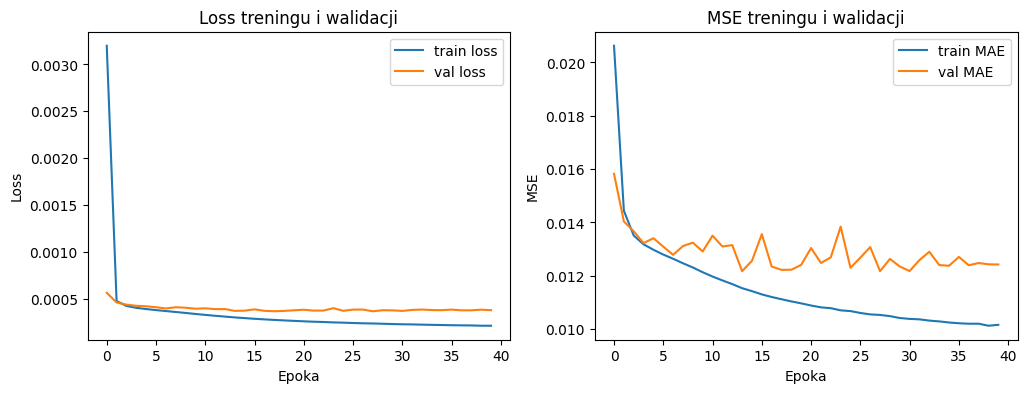

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.title('Loss treningu i walidacji')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.xlabel('Epoka')
plt.ylabel('MSE')
plt.title('MSE treningu i walidacji')
plt.legend()

plt.show()

In [9]:
#drugi model
train_ds = make_tf_dataset("training_Positional/train_*.npz", batch_size=batch)
test_ds  = make_tf_dataset("training_Positional/test_*.npz",  batch_size=batch)

best_hp = tuner.get_best_hyperparameters(1)[0]
model2 = build_dense_model(best_hp)
history = model2.fit(
    train_ds,
    validation_data=test_ds,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs=500,
    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=12,
            restore_best_weights=True
        )
    ]
)


Epoch 1/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 219s 23ms/step - loss: 0.0031 - mae: 0.0202 - val_loss: 5.7677e-04 - val_mae: 0.0156
Epoch 2/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 218s 23ms/step - loss: 4.5022e-04 - mae: 0.0139 - val_loss: 4.2088e-04 - val_mae: 0.0131
Epoch 3/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 214s 23ms/step - loss: 4.0338e-04 - mae: 0.0130 - val_loss: 4.5627e-04 - val_mae: 0.0149
Epoch 4/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 214s 23ms/step - loss: 3.8697e-04 - mae: 0.0128 - val_loss: 4.1929e-04 - val_mae: 0.0132
Epoch 5/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 212s 23ms/step - loss: 3.7622e-04 - mae: 0.0126 - val_loss: 4.0524e-04 - val_mae: 0.0127
Epoch 6/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 211s 23ms/step - loss: 3.6651e-04 - mae: 0.0125 - val_loss: 4.0809e-04 - val_mae: 0.0130
Epoch 7/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 215s 23ms/step - loss: 3.5686e-04 - mae: 0.0123 - val_loss: 3.8649e-04 - val_mae: 0.0124
Epoch 8/500
9375/9375 ━━━━━━━━━━━━━━━━━━━━ 216s 23ms/step - loss: 3.4746e-04 - m

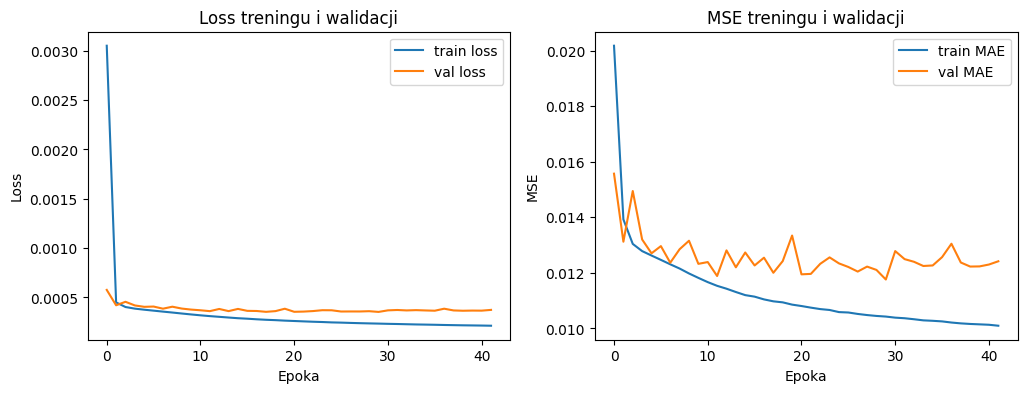

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoka')
plt.ylabel('Loss')
plt.title('Loss treningu i walidacji')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='train MAE')
plt.plot(history.history['val_mae'], label='val MAE')
plt.xlabel('Epoka')
plt.ylabel('MSE')
plt.title('MSE treningu i walidacji')
plt.legend()

plt.show()

In [ ]:

model.save('agresive.keras')
model2.save('positional.keras')

In [ ]:
model2bin(model)
model2bin(model2)

In [ ]:
from tensorflow.keras.models import load_model
model3 = load_model('models/agresive-v15.keras')
model2bin(model3)